In [2]:
cd /content/drive/MyDrive/[Projects]/AI Hub/Pose Detection 기반 실시간 낙상 감지 시스템 개발/Data

/content/drive/MyDrive/[Projects]/AI Hub/Pose Detection 기반 실시간 낙상 감지 시스템 개발/Data


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import random
import torch
import numpy as np

def fix_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
import pandas as pd

def load_csv(csv_path):
    df = pd.read_csv(csv_path)
    df.sort_values(["file", "frame"], inplace=True)
    return df

def make_input(df, window_size=10, stride=1, joints=17):
    x_data = []
    y_data = []

    for file, group in df.groupby('file'):
        group = group.sort_values('frame')

        labels = group['label'].values

        col_x = [c for c in df.columns if c.endswith('_x')]
        col_y = [c for c in df.columns if c.endswith('_y')]
        col_s = [c for c in df.columns if c.endswith('_score')]

        data_x = group[col_x].values
        data_y = group[col_y].values
        data_s = group[col_s].values

        total = len(group)
        for start in range(0, total - window_size + 1, stride):
            end = start + window_size

            win_x = data_x[start:end]
            win_y = data_y[start:end]
            win_s = data_s[start:end]

            win = np.stack([win_x, win_y, win_s], axis=0)

            win = np.expand_dims(win, axis=-1)

            x_data.append(win)

            window_label = max(set(labels[start:end]), key=list(labels[start:end]).count)
            y_data.append(window_label)

    x_data = torch.tensor(np.array(x_data), dtype=torch.float32).squeeze(-1)
    y_data = torch.tensor(np.array(y_data), dtype=torch.long)

    return x_data, y_data

train_df = pd.read_csv('output_train.csv')

train_df = train_df.interpolate().fillna(0)

x_data, y_data = make_input(train_df)
x_data.shape, y_data.shape

(torch.Size([377848, 3, 10, 17]), torch.Size([377848]))

In [6]:
def get_coco_adjacency():
    edges = [
        (0, 1), (0, 2),        # nose to eyes
        (1, 3), (2, 4),        # eye to ear
        (0, 5), (0, 6),        # nose to shoulders
        (5, 7), (7, 9),        # left arm
        (6, 8), (8, 10),       # right arm
        (5, 11), (6, 12),      # shoulder to hip
        (11, 13), (13, 15),    # left leg
        (12, 14), (14, 16),    # right leg
        (11, 12)               # hip connection
    ]

    A = np.zeros((17, 17))

    for i, j in edges:
        A[i, j] = 1
        A[j, i] = 1

    for i in range(17):
        A[i, i] = 1

    return A

A = get_coco_adjacency()
A.shape

(17, 17)

In [7]:
import torch.nn as nn

class STGCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, A, kernel_size=9):
        super().__init__()

        self.A = nn.Parameter(torch.tensor(A, dtype=torch.float32), requires_grad=False)

        self.gcn_conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=1
        )

        pad = (kernel_size - 1) // 2
        self.tcn_conv = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=(kernel_size, 1),
            padding=(pad, 0)
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x_spatial = torch.einsum('nctv,vw->nctw', x, self.A)

        x_spatial = self.gcn_conv(x_spatial)

        x_temporal = self.tcn_conv(x_spatial)

        out = self.relu(x_temporal)

        return out

block = STGCNBlock(in_channels=3, out_channels=64, A=A)

x = torch.randn(2, 3, 30, 17)
y = block(x)
y.shape

torch.Size([2, 64, 30, 17])

In [8]:
class STGCN(nn.Module):
    def __init__(self, A, T=30, V=17):
        super().__init__()

        self.block1 = STGCNBlock(3, 64, A)
        self.block2 = STGCNBlock(64, 64, A)
        self.block3 = STGCNBlock(64, 128, A)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        x = self.pool(x)
        x = x.view(x.size(0), -1)

        out = self.fc(x)
        return out

model = STGCN(A=A)

x = torch.randn(4, 3, 30, 17)
y = model(x)
y.shape

torch.Size([4, 1])

In [9]:
from torch.utils.data import Dataset

class PoseDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.x[idx], dtype=torch.float32),
            torch.tensor(self.y[idx], dtype=torch.long)
        )

In [10]:
from torch.utils.data import DataLoader, TensorDataset

def train_model(train_x, train_y, val_x, val_y, epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_dataset = PoseDataset(train_x, train_y)
    val_dataset = PoseDataset(val_x, val_y)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
    valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    model = STGCN(A=A)
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y.float().unsqueeze(1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        valid_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for x, y in valid_loader:
                x = x.to(device)
                y = y.to(device)

                out = model(x)
                loss = criterion(out, y.float().unsqueeze(1))
                valid_loss += loss.item()

                prob = torch.sigmoid(out)
                pred = (prob > 0.5).long()

                correct += (pred.squeeze() == y).sum().item()
                total += len(y)

        valid_loss /= len(valid_loader)
        valid_acc = correct / total

        print(
            f"[Epoch {epoch+1}/{epochs}] "
            f"Train Loss: {train_loss:.4f} | "
            f"Valid Loss: {valid_loss:.4f} | "
            f"Valid Acc: {valid_acc:.4f}"
        )

    return model

In [11]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate(model, x_val, y_val, threshold=0.5):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()

    preds = []
    probs = []

    ds = TensorDataset(
        torch.tensor(x_val).float(),
        torch.tensor(y_val).float()
    )
    loader = DataLoader(ds, batch_size=64, shuffle=False)

    with torch.no_grad():
        for seq, label in loader:
            seq = seq.to(device)

            logits = model(seq).squeeze()

            prob = torch.sigmoid(logits)

            probs.extend(prob.cpu().numpy())
            preds.extend((prob > threshold).cpu().numpy())

    preds = np.array(preds)
    probs = np.array(probs)
    y_val = np.array(y_val)

    cm = confusion_matrix(y_val, preds)
    precision = precision_score(y_val, preds, zero_division=0)
    recall    = recall_score(y_val, preds, zero_division=0)
    f1        = f1_score(y_val, preds, zero_division=0)

    print("\n📌 CONFUSION MATRIX")
    print(cm)
    print(f"\nPrecision = {precision:.4f}")
    print(f"Recall    = {recall:.4f}")
    print(f"F1        = {f1:.4f}")

    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidth=.5)
    plt.title(f"Threshold = {threshold}")
    plt.show()

    return f1, precision, recall, cm

In [12]:
def find_best_threshold(model, x_val, y_val):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()

    thresholds = np.arange(0.1, 1.0, 0.1)

    # dataloader 생성
    ds = TensorDataset(
        torch.tensor(x_val).float(),
        torch.tensor(y_val).float()
    )
    loader = DataLoader(ds, batch_size=64, shuffle=False)

    # logits 전체 저장
    all_logits = []

    with torch.no_grad():
        for seq, _ in loader:
            seq = seq.to(device)
            logits = model(seq).squeeze()
            all_logits.extend(logits.cpu().numpy())

    all_logits = np.array(all_logits)
    all_probs  = torch.sigmoid(torch.tensor(all_logits)).numpy()

    best_f1 = -1
    best_th = None

    for th in thresholds:
        preds = (all_probs > th).astype(int)
        f1 = f1_score(y_val, preds, zero_division=0)

        if f1 > best_f1:
            best_f1 = f1
            best_th = th

    return best_th

In [13]:
train_df = load_csv("output_train.csv")
val_df   = load_csv("output_val.csv")

In [14]:
train_df = train_df.interpolate().fillna(0)
val_df = val_df.interpolate(). fillna(0)

In [14]:
window_to_model = {}
window_to_threshold = {}
results = []

torch.Size([377848, 3, 10, 17]) torch.Size([377848])
[Epoch 1/10] Train Loss: 0.1805 | Valid Loss: 0.1007 | Valid Acc: 0.9684
[Epoch 2/10] Train Loss: 0.0964 | Valid Loss: 0.0958 | Valid Acc: 0.9697
[Epoch 3/10] Train Loss: 0.0900 | Valid Loss: 0.0906 | Valid Acc: 0.9694
[Epoch 4/10] Train Loss: 0.0860 | Valid Loss: 0.0868 | Valid Acc: 0.9706
[Epoch 5/10] Train Loss: 0.0847 | Valid Loss: 0.0863 | Valid Acc: 0.9698
[Epoch 6/10] Train Loss: 0.0819 | Valid Loss: 0.0862 | Valid Acc: 0.9706
[Epoch 7/10] Train Loss: 0.0789 | Valid Loss: 0.0864 | Valid Acc: 0.9715
[Epoch 8/10] Train Loss: 0.0803 | Valid Loss: 0.0861 | Valid Acc: 0.9694
[Epoch 9/10] Train Loss: 0.0780 | Valid Loss: 0.0826 | Valid Acc: 0.9722
[Epoch 10/10] Train Loss: 0.0782 | Valid Loss: 0.0812 | Valid Acc: 0.9712
best threshold = 0.4

📌 CONFUSION MATRIX
[[50426   654]
 [  942  1850]]

Precision = 0.7388
Recall    = 0.6626
F1        = 0.6986


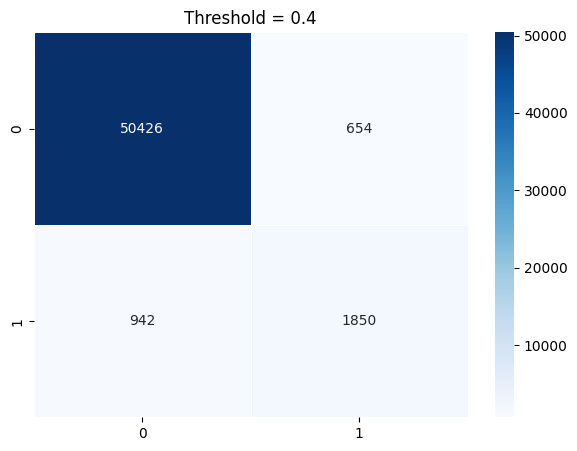

In [15]:
WINDOW = 10

fix_seed(42)

x_train, y_train = make_input(train_df, window_size=WINDOW)
x_val, y_val     = make_input(val_df, window_size=WINDOW)

print(x_train.shape, y_train.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_10 = train_model(x_train, y_train, x_val, y_val)

best_th_10 = find_best_threshold(model_10, x_val, y_val)
print("best threshold =", best_th_10)

window_to_model[WINDOW] = model_10
window_to_threshold[WINDOW] = best_th_10

f1, precision, recall, cm = evaluate(model_10, x_val, y_val, threshold=best_th_10)

results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

torch.Size([336568, 3, 20, 17]) torch.Size([336568])
[Epoch 1/10] Train Loss: 0.2502 | Valid Loss: 0.1055 | Valid Acc: 0.9639
[Epoch 2/10] Train Loss: 0.0963 | Valid Loss: 0.1116 | Valid Acc: 0.9616
[Epoch 3/10] Train Loss: 0.1026 | Valid Loss: 0.1117 | Valid Acc: 0.9618
[Epoch 4/10] Train Loss: 0.0917 | Valid Loss: 0.1058 | Valid Acc: 0.9656
[Epoch 5/10] Train Loss: 0.2179 | Valid Loss: 0.2177 | Valid Acc: 0.9433
[Epoch 6/10] Train Loss: 0.2135 | Valid Loss: 0.2177 | Valid Acc: 0.9433
[Epoch 7/10] Train Loss: 0.2135 | Valid Loss: 0.2177 | Valid Acc: 0.9433
[Epoch 8/10] Train Loss: 0.2438 | Valid Loss: 0.2177 | Valid Acc: 0.9433
[Epoch 9/10] Train Loss: 0.8500 | Valid Loss: 0.2177 | Valid Acc: 0.9433
[Epoch 10/10] Train Loss: 0.2135 | Valid Loss: 0.2177 | Valid Acc: 0.9433
best threshold = 0.1

📌 CONFUSION MATRIX
[[45232     0]
 [ 2720     0]]

Precision = 0.0000
Recall    = 0.0000
F1        = 0.0000


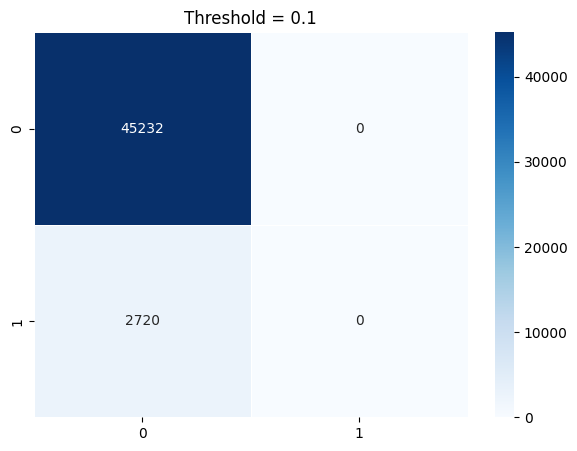

In [16]:
WINDOW = 20

fix_seed(42)

x_train, y_train = make_input(train_df, window_size=WINDOW)
x_val, y_val     = make_input(val_df, window_size=WINDOW)

print(x_train.shape, y_train.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_20 = train_model(x_train, y_train, x_val, y_val)

best_th_20 = find_best_threshold(model_20, x_val, y_val)
print("best threshold =", best_th_20)

window_to_model[WINDOW] = model_20
window_to_threshold[WINDOW] = best_th_20

f1, precision, recall, cm = evaluate(model_20, x_val, y_val, threshold=best_th_20)

results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

torch.Size([295288, 3, 30, 17]) torch.Size([295288])
[Epoch 1/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 2/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 3/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 4/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 5/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 6/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 7/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 8/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 9/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 10/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
best threshold = 0.1

📌 CONFUSION MATRIX
[[42032]]

Precision = 0.0000
Recall    = 0.0000
F1        = 0.0000


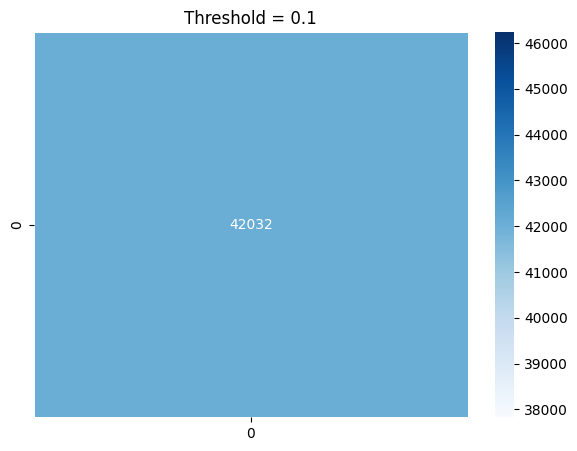

In [17]:
WINDOW = 30

fix_seed(42)

x_train, y_train = make_input(train_df, window_size=WINDOW)
x_val, y_val     = make_input(val_df, window_size=WINDOW)

print(x_train.shape, y_train.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_30 = train_model(x_train, y_train, x_val, y_val)

best_th_30 = find_best_threshold(model_30, x_val, y_val)
print("best threshold =", best_th_30)

window_to_model[WINDOW] = model_30
window_to_threshold[WINDOW] = best_th_30

f1, precision, recall, cm = evaluate(model_30, x_val, y_val, threshold=best_th_30)

results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

torch.Size([254008, 3, 40, 17]) torch.Size([254008])
[Epoch 1/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 2/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 3/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 4/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 5/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 6/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 7/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 8/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 9/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 10/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
best threshold = 0.1

📌 CONFUSION MATRIX
[[36112]]

Precision = 0.0000
Recall    = 0.0000
F1        = 0.0000


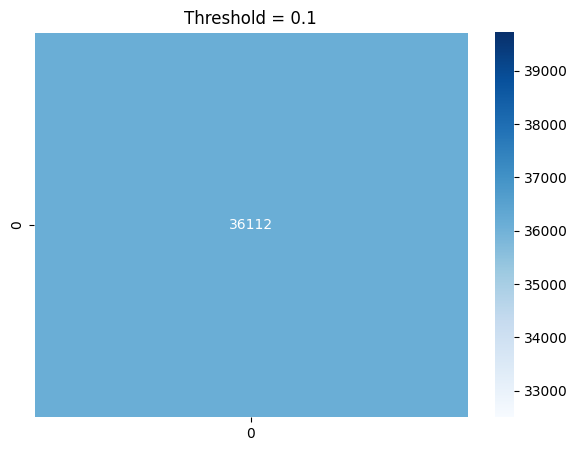

In [18]:
WINDOW = 40

fix_seed(42)

x_train, y_train = make_input(train_df, window_size=WINDOW)
x_val, y_val     = make_input(val_df, window_size=WINDOW)

print(x_train.shape, y_train.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_40 = train_model(x_train, y_train, x_val, y_val)

best_th_40 = find_best_threshold(model_40, x_val, y_val)
print("best threshold =", best_th_40)

window_to_model[WINDOW] = model_40
window_to_threshold[WINDOW] = best_th_40

f1, precision, recall, cm = evaluate(model_40, x_val, y_val, threshold=best_th_40)

results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

torch.Size([212728, 3, 50, 17]) torch.Size([212728])
[Epoch 1/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 2/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 3/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 4/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 5/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 6/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 7/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 8/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 9/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
[Epoch 10/10] Train Loss: 0.0000 | Valid Loss: 0.0000 | Valid Acc: 1.0000
best threshold = 0.1

📌 CONFUSION MATRIX
[[30192]]

Precision = 0.0000
Recall    = 0.0000
F1        = 0.0000


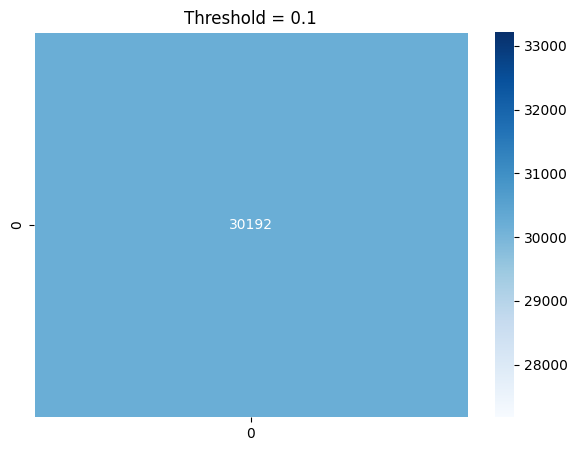

In [19]:
WINDOW = 50

fix_seed(42)

x_train, y_train = make_input(train_df, window_size=WINDOW)
x_val, y_val     = make_input(val_df, window_size=WINDOW)

print(x_train.shape, y_train.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_50 = train_model(x_train, y_train, x_val, y_val)

best_th_50 = find_best_threshold(model_50, x_val, y_val)
print("best threshold =", best_th_50)

window_to_model[WINDOW] = model_50
window_to_threshold[WINDOW] = best_th_50

f1, precision, recall, cm = evaluate(model_50, x_val, y_val, threshold=best_th_50)

results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

In [20]:
result_df = pd.DataFrame(results)
result_df

,Window size,F1-Score,Precision,Recall
0,10,0.69864,0.738818,0.662607
1,20,0.00000,0.000000,0.000000
2,30,0.00000,0.000000,0.000000
3,40,0.00000,0.000000,0.000000
4,50,0.00000,0.000000,0.000000


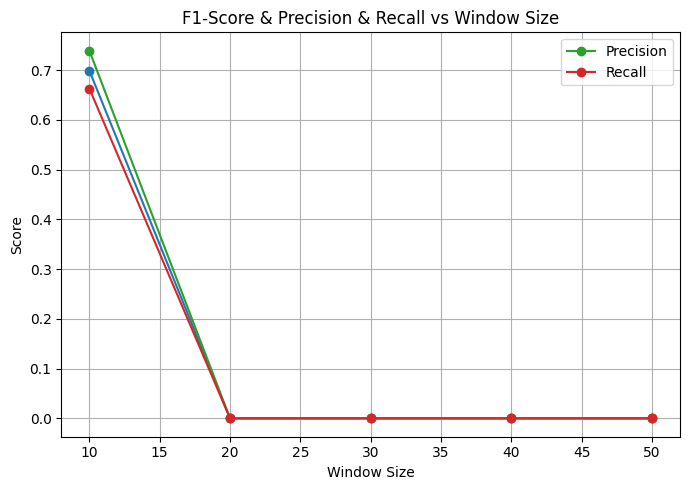

In [21]:
plt.figure(figsize=(7,5))

plt.plot(result_df['Window size'], result_df['F1-Score'], marker='o', color='tab:blue')
plt.plot(result_df['Window size'], result_df['Precision'], marker='o', label='Precision', color='tab:green')
plt.plot(result_df['Window size'], result_df['Recall'], marker='o', label='Recall', color='tab:red')
plt.title('F1-Score & Precision & Recall vs Window Size')
plt.xlabel('Window Size')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [21]:
from torch.utils.data import DataLoader, TensorDataset

def train_model_with_weight(train_x, train_y, val_x, val_y, epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_dataset = PoseDataset(train_x, train_y)
    val_dataset = PoseDataset(val_x, val_y)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
    valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    model = STGCN(A=A)
    model.to(device)

    pos = (y_train == 1).sum()
    neg = (y_train == 0).sum()

    pos_weight = neg / pos

    criterion = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor(pos_weight).to(device)
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y.float().unsqueeze(1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        valid_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for x, y in valid_loader:
                x = x.to(device)
                y = y.to(device)

                out = model(x)
                loss = criterion(out, y.float().unsqueeze(1))
                valid_loss += loss.item()

                prob = torch.sigmoid(out)
                pred = (prob > 0.5).long()

                correct += (pred.squeeze() == y).sum().item()
                total += len(y)

        valid_loss /= len(valid_loader)
        valid_acc = correct / total

        print(
            f"[Epoch {epoch+1}/{epochs}] "
            f"Train Loss: {train_loss:.4f} | "
            f"Valid Loss: {valid_loss:.4f} | "
            f"Valid Acc: {valid_acc:.4f}"
        )

    return model

In [20]:
window_to_model = {}
window_to_threshold = {}
results = []

torch.Size([377848, 3, 10, 17]) torch.Size([377848])
[Epoch 1/10] Train Loss: 0.8102 | Valid Loss: 0.5793 | Valid Acc: 0.9193
[Epoch 2/10] Train Loss: 0.6854 | Valid Loss: 0.6673 | Valid Acc: 0.9461
[Epoch 3/10] Train Loss: 1.0817 | Valid Loss: 1.3594 | Valid Acc: 0.9481
[Epoch 4/10] Train Loss: 1.3185 | Valid Loss: 1.3534 | Valid Acc: 0.9482
[Epoch 5/10] Train Loss: 1.3182 | Valid Loss: 1.3531 | Valid Acc: 0.9482
[Epoch 6/10] Train Loss: 1.3182 | Valid Loss: 1.3520 | Valid Acc: 0.0518
[Epoch 7/10] Train Loss: 1.3182 | Valid Loss: 1.3528 | Valid Acc: 0.9482
[Epoch 8/10] Train Loss: 1.3182 | Valid Loss: 1.3532 | Valid Acc: 0.9482
[Epoch 9/10] Train Loss: 1.3184 | Valid Loss: 1.3528 | Valid Acc: 0.9482
[Epoch 10/10] Train Loss: 1.3182 | Valid Loss: 1.3532 | Valid Acc: 0.9482
best threshold = 0.1

📌 CONFUSION MATRIX
[[    0 51080]
 [    0  2792]]

Precision = 0.0518
Recall    = 1.0000
F1        = 0.0985


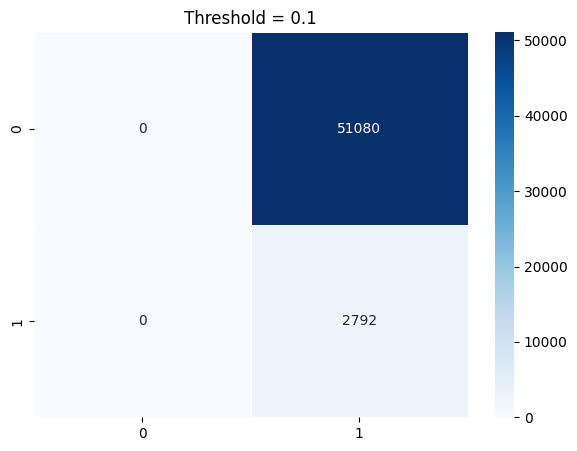

In [22]:
WINDOW = 10

fix_seed(42)

x_train, y_train = make_input(train_df, window_size=WINDOW)
x_val, y_val     = make_input(val_df, window_size=WINDOW)

print(x_train.shape, y_train.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_10 = train_model_with_weight(x_train, y_train, x_val, y_val)

best_th_10 = find_best_threshold(model_10, x_val, y_val)
print("best threshold =", best_th_10)

window_to_model[WINDOW] = model_10
window_to_threshold[WINDOW] = best_th_10

f1, precision, recall, cm = evaluate(model_10, x_val, y_val, threshold=best_th_10)

results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

torch.Size([336568, 3, 20, 17]) torch.Size([336568])
[Epoch 1/10] Train Loss: 0.7556 | Valid Loss: 0.5886 | Valid Acc: 0.9341
[Epoch 2/10] Train Loss: 0.5677 | Valid Loss: 0.7785 | Valid Acc: 0.9534
[Epoch 3/10] Train Loss: 0.5817 | Valid Loss: 1.4041 | Valid Acc: 0.9429
[Epoch 4/10] Train Loss: 1.3142 | Valid Loss: 1.3266 | Valid Acc: 0.9433
[Epoch 5/10] Train Loss: 1.3100 | Valid Loss: 1.3267 | Valid Acc: 0.9433
[Epoch 6/10] Train Loss: 1.3100 | Valid Loss: 1.3265 | Valid Acc: 0.0567
[Epoch 7/10] Train Loss: 1.3098 | Valid Loss: 1.3267 | Valid Acc: 0.9433
[Epoch 8/10] Train Loss: 1.3099 | Valid Loss: 1.3265 | Valid Acc: 0.0567
[Epoch 9/10] Train Loss: 1.3099 | Valid Loss: 1.3267 | Valid Acc: 0.9433
[Epoch 10/10] Train Loss: 1.3099 | Valid Loss: 1.3264 | Valid Acc: 0.0567
best threshold = 0.1

📌 CONFUSION MATRIX
[[    0 45232]
 [    0  2720]]

Precision = 0.0567
Recall    = 1.0000
F1        = 0.1074


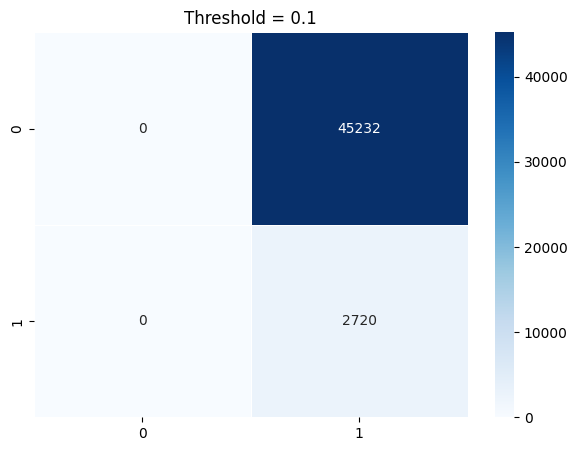

In [23]:
WINDOW = 20

fix_seed(42)

x_train, y_train = make_input(train_df, window_size=WINDOW)
x_val, y_val     = make_input(val_df, window_size=WINDOW)

print(x_train.shape, y_train.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_20 = train_model_with_weight(x_train, y_train, x_val, y_val)

best_th_20 = find_best_threshold(model_20, x_val, y_val)
print("best threshold =", best_th_20)

window_to_model[WINDOW] = model_20
window_to_threshold[WINDOW] = best_th_20

f1, precision, recall, cm = evaluate(model_20, x_val, y_val, threshold=best_th_20)

results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

torch.Size([295288, 3, 30, 17]) torch.Size([295288])
[Epoch 1/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 2/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 3/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 4/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 5/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 6/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 7/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 8/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 9/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 10/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
best threshold = 0.1

📌 CONFUSION MATRIX
[[42032]]

Precision = 0.0000
Recall    = 0.0000
F1        = 0.0000


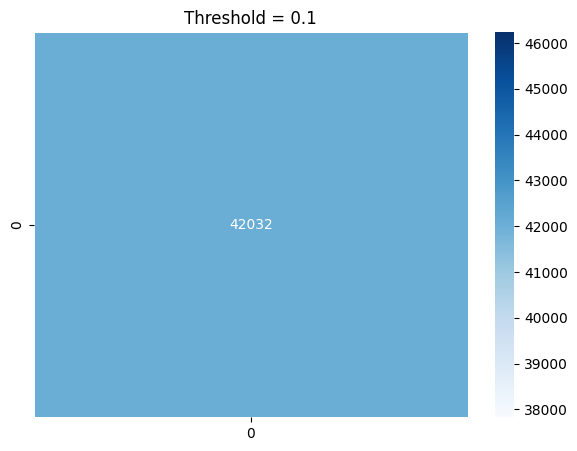

In [24]:
WINDOW = 30

fix_seed(42)

x_train, y_train = make_input(train_df, window_size=WINDOW)
x_val, y_val     = make_input(val_df, window_size=WINDOW)

print(x_train.shape, y_train.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_30 = train_model_with_weight(x_train, y_train, x_val, y_val)

best_th_30 = find_best_threshold(model_30, x_val, y_val)
print("best threshold =", best_th_30)

window_to_model[WINDOW] = model_30
window_to_threshold[WINDOW] = best_th_30

f1, precision, recall, cm = evaluate(model_30, x_val, y_val, threshold=best_th_30)

results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

torch.Size([254008, 3, 40, 17]) torch.Size([254008])
[Epoch 1/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 2/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 3/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 4/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 5/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 6/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 7/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 8/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 9/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 10/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
best threshold = 0.1

📌 CONFUSION MATRIX
[[36112]]

Precision = 0.0000
Recall    = 0.0000
F1        = 0.0000


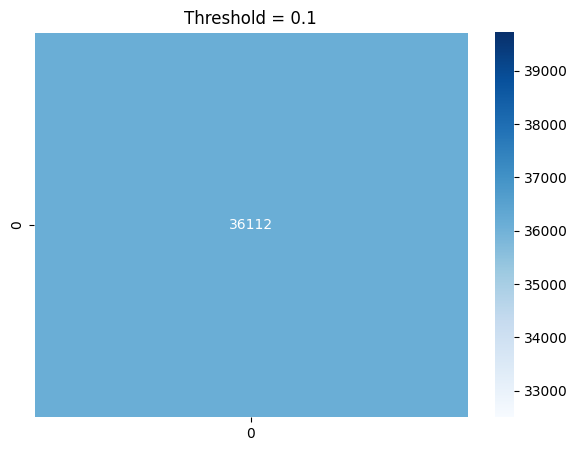

In [25]:
WINDOW = 40

fix_seed(42)

x_train, y_train = make_input(train_df, window_size=WINDOW)
x_val, y_val     = make_input(val_df, window_size=WINDOW)

print(x_train.shape, y_train.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_40 = train_model_with_weight(x_train, y_train, x_val, y_val)

best_th_40 = find_best_threshold(model_40, x_val, y_val)
print("best threshold =", best_th_40)

window_to_model[WINDOW] = model_40
window_to_threshold[WINDOW] = best_th_40

f1, precision, recall, cm = evaluate(model_40, x_val, y_val, threshold=best_th_40)

results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

torch.Size([212728, 3, 50, 17]) torch.Size([212728])
[Epoch 1/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 2/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 3/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 4/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 5/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 6/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 7/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 8/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 9/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
[Epoch 10/10] Train Loss: nan | Valid Loss: nan | Valid Acc: 1.0000
best threshold = 0.1

📌 CONFUSION MATRIX
[[30192]]

Precision = 0.0000
Recall    = 0.0000
F1        = 0.0000


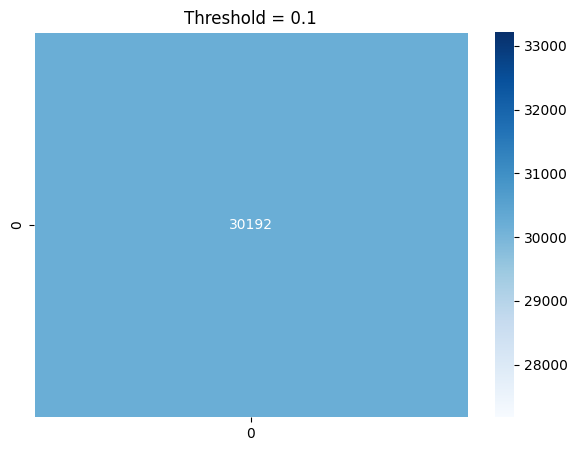

In [26]:
WINDOW = 50

fix_seed(42)

x_train, y_train = make_input(train_df, window_size=WINDOW)
x_val, y_val     = make_input(val_df, window_size=WINDOW)

print(x_train.shape, y_train.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_50 = train_model_with_weight(x_train, y_train, x_val, y_val)

best_th_50 = find_best_threshold(model_50, x_val, y_val)
print("best threshold =", best_th_50)

window_to_model[WINDOW] = model_50
window_to_threshold[WINDOW] = best_th_50

f1, precision, recall, cm = evaluate(model_50, x_val, y_val, threshold=best_th_50)

results.append({
    'Window size': WINDOW,
    'F1-Score': f1,
    'Precision': precision,
    'Recall': recall
})

In [28]:
result_df = pd.DataFrame(results)
result_df

,Window size,F1-Score,Precision,Recall
0,10,0.098546,0.051827,1.0
1,20,0.107357,0.056723,1.0
2,30,0.000000,0.000000,0.0
3,40,0.000000,0.000000,0.0
4,50,0.000000,0.000000,0.0


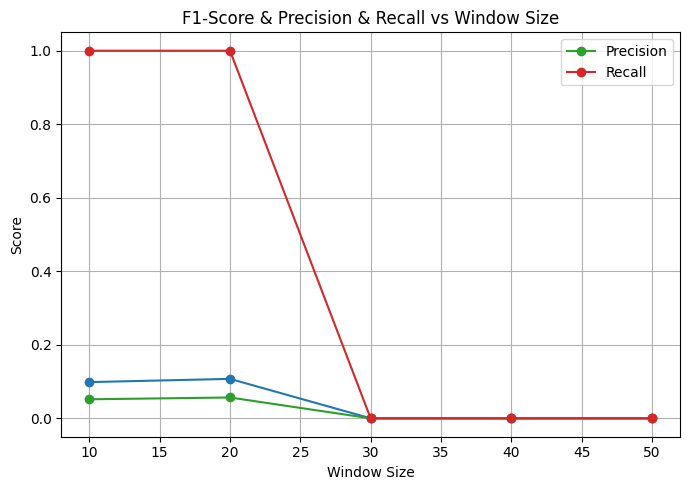

In [29]:
plt.figure(figsize=(7,5))

plt.plot(result_df['Window size'], result_df['F1-Score'], marker='o', color='tab:blue')
plt.plot(result_df['Window size'], result_df['Precision'], marker='o', label='Precision', color='tab:green')
plt.plot(result_df['Window size'], result_df['Recall'], marker='o', label='Recall', color='tab:red')
plt.title('F1-Score & Precision & Recall vs Window Size')
plt.xlabel('Window Size')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()